# DATASCI W261: Machine Learning at Scale

# Danny Wudka, Bovard Tiberi, Gopala Tumuluri Submission for HW7

## Problem - 7.0

In this part, we write a shortest path algorithm using MRJob and MapReduce that take a 'source' node as input - configured in mapper_init, and finds the shortest path - the actual path and the distance - to a selected destination - configured in the driver code.

**Note that this is the same base code used for all shortest path distance problems (7.0, and 7.4) for undirected_toy.txt, directed_toy.txt, synNet.txt and the wikipedia dataset. The code itself is repeated in different parts for clarity and continuity. Documentation WILL NOT be repeated.**

It has three main MRJob classes, each with its own steps. These three MRJob classes perform the following MapReduce tasks, and are invoked at the right time:

1) **MRGraphInit** - This MRJob task reads the adjacency list as input and outputs the 'graph' in the same format the shortest path algorithm will process each iteration. A source node is configured in the mapper_init function. This MRJob task will place the source node 'on the frontier' tagged as in the queue (status = 'Q') and every other node as unvisited (status = 'U'). The key value output follows this format - **node, (neighbors, path, path distance, status)** The same format is used throughout the cycle to ensure proper handling of data. **note: this class does not have a reducer**.

2) **MRShortestPath** - This MRJob task is the heart of the shortest path algirthm, which marks nodes that are not in the stream any longer as visited, places new nodes that are neigbors of just visited nodes into the steam as being on the frontier (status = 'Q') with a null path to allow the reducer to process the nodes in the frontier and pick the shorted distance among all available paths to this node. The key value output follows the same format as above to ensure commond interpretation throughout the mapreduce cylce.

3) **MRCheckDestinationNode** - This MRJob task simply yields the nodes that have been visited so that the driver can check if the **destination node** of interest has already been visited from the source node that was configured. This will allow the driver to terminate the jobs and output the shortest path from the source node to the destination node. IF the destination node has not been visited, the driver will iterate **one more time through the MRShortestPath** job to check again, and repeat the process until the destination node is visited. **note: this class does not have a reducer**.


In [14]:
%%writefile mrjob_7_0.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

# This class explained above.
class MRGraphInit(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                       mapper = self.mapper
                       )]
    
    # Initialize the source node of interst
    def mapper_init(self):
        self.source_node = '1'
        
    # Output graph in the form shortest path code will use and place
    # source node in the Q since its the default frontier.
    def mapper(self, _, line):
        line = line.strip('\n')
        node, neighbors = line.split('\t')
        neighbors = ast.literal_eval(neighbors)
        
        if node == self.source_node:
            yield node, (neighbors.keys(), [node], 0, 'Q')
        else:
            yield node, (neighbors.keys(), [], sys.maxsize, 'U')        
        
class MRShortestPath(MRJob):
    
    def steps(self):
        return [MRStep(mapper = self.bfs_mapper,
                       reducer = self.bfs_reducer)]
    
    # Place nodes completed in visited state and keep opening the frontier
    # by placing new neighboring nodes in the Q.
    def bfs_mapper(self, _, line):
        line = line.strip('\n')
        
        key, value = line.split('\t')
        key = key.replace('"', '')
        neighbors, path, distance, status = ast.literal_eval(value)
        
        # If a node was in visited or unvisited state, nothing to do. Ship it over.
        if status == 'V' or status == 'U':
            yield key, (neighbors, path, distance, status)
        else:
            # If a node was in Q status in previous map step, it would have
            # been processed by reducer, and we are done with it. Mark it visited.
            # So, place it in the Q, and open up its neighbors as the new frontier
            # nodes by placing them in Q.
            yield key, (neighbors, path, distance, 'V')
            for node in neighbors:
                yield node, ('NULL', path, int(distance) + 1, 'Q')
    
    def bfs_reducer(self, key, values):
        # Some local variables to compare and store final distance, path
        # and status to set multiple lines of output from mapper for a given
        # node. Consolidate lines to carry final path, distance and Q status
        # through to the mapper again.
        min_distance = sys.maxsize
        statuses = {}
        final_neighbors = []
        current_path = None
        
        # This loop will only be relevant for 'frontier nodes' in Q.
        for neighbors, path, distance, status in values:
            statuses[status] = 1;
            # If we lines with not the max distance (infinity), we should
            # Take these distances as our distance to this node. Works ONLY
            # for unweighted graphs.
            if distance < min_distance:
                min_distance = distance
                current_path = path
            # Pick the nighbors from the non-'NULL' line - repeat of original line
            # in the graph.
            if neighbors != 'NULL':
                final_neighbors = neighbors
        # If something was in visited state alread, nothing to do. Send it along.
        if 'V' in statuses:
            yield key, (final_neighbors, path, min_distance, 'V')
        # If a node is in Q, append to its path the source of how it got
        # into the frontier land (into the Q) and output the node.
        elif 'Q' in statuses:
            current_path.append(key)
            yield key, (final_neighbors, current_path, min_distance, 'Q')
        else:
            # If this was an unvisited node, keep passing it along
            yield key, (neighbors, path, distance, status)

class MRCheckDestinationNode(MRJob):
    def steps(self):
        return [MRStep(mapper = self.frontier_mapper)]
    
    # A very simple mapper that outputs nodes that are in visited state
    # so the driver can check if desired node has been visited and terminate.
    def frontier_mapper(self, _, line):
        line = line.strip('\n')
        line = line.split('\t')
        
        items = ast.literal_eval(line[1])
        if (items[-1] == 'V'):
            yield line[0], (items[-1], items[1], items[2])
    

Overwriting mrjob_7_0.py


## Problem - 7.0 - undirected_toy.txt run

In this part, we write the driver code that will use the above three MRJob classes to process the shortest path algorithm between a pair of nodes (source initiated above) and a destination speicifed below.

The driver does the following:

1) Initializes the graph into the steam

2) Runs one iteration of shortest path MRJob

3) Runs another MRJob that outputs visited nodes

4) Checks if the destination node is in output

5) Otherwise, repeats step #2 onwards UNTIL this condition is met.

6) AFTER destination node is visited, terminates  and outputs the shortest path from the source to destination.

**This driver is used repeatedly throughout and this documentation won't be repeated**

In [19]:
%reload_ext autoreload
%autoreload 2

from mrjob_7_0 import MRGraphInit, MRShortestPath, MRCheckDestinationNode

# Initialize needed jobs.
mr_job1 = MRGraphInit(args=['undirected_toy.txt', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job2 = MRShortestPath(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job3 = MRCheckDestinationNode(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--no-strict-protocols'])

# Initialize graph into stream
with mr_job1.make_runner() as runner:
    runner.run()

# Set source, target and whether reached
source_node = '1'
destination_node = '4'
destination_found = False

# Dump all computed paths into an output file for later processing
outfile = open('/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/paths.txt', 'w')

# Iterate until target node is in visited state
iterations = 0
while(iterations < 10):
    with mr_job2.make_runner() as runner: 
        runner.run()
    with mr_job3.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            key, value =  mr_job3.parse_output_line(line)
            key = key.replace('"', '')
            # If any node in visited, write the path to file. Creates duplicates, but that is fine.
            if value[0] == 'V':
                line = line.replace('"', '')
                line = line.replace('\\', '')
                outfile.write(line + '\n')
            # IF found target node in visited, output the path and be done.
            if key == destination_node and value[0] == 'V':
                print (source_node, destination_node), (value[1], value[2])
                destination_found = True
                break

    if destination_found:
        break

    iterations += 1

outfile.close()

('1', '4') (['1', '2', '4'], 2)


## Problem - 7.0 - directed_toy.txt run

Here we run the same driver on the directed toy graph, and show the output of the shortest path.

In [48]:
%reload_ext autoreload
%autoreload 2

from mrjob_7_0 import MRGraphInit, MRShortestPath, MRCheckDestinationNode

mr_job1 = MRGraphInit(args=['directed_toy.txt', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job2 = MRShortestPath(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job3 = MRCheckDestinationNode(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--no-strict-protocols'])

with mr_job1.make_runner() as runner:
    runner.run()

source_node = '1'
destination_node = '5'
destination_found = False

outfile = open('/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/paths.txt', 'w')

iterations = 0
while(iterations < 10):
    with mr_job2.make_runner() as runner: 
        runner.run()
    with mr_job3.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            key, value =  mr_job3.parse_output_line(line)
            key = key.replace('"', '')
            if value[0] == 'V':
                line = line.replace('"', '')
                line = line.replace('\\', '')
                outfile.write(line + '\n')
            if key == destination_node and value[0] == 'V':
                print (source_node, destination_node), (value[1], value[2])
                destination_found = True
                break

    if destination_found:
        break

    iterations += 1

outfile.close()

('1', '5') (['1', '2', '4', '5'], 3)


## Problem 7.1 - Exploratory Data Analysis on Synonym Network Graph

In this section, we use two MRJob classes to compute all needed statistics about the graph.

1) **MRDegreeDistribution** - The first MRJob class is used to compute the degree distribution of the graph and plot the histogram. To do this, we find out the number of times a given degree occurs through the MRJob task. The mapper outputs the number of neighbors of a given node, and the reducer counts the number of nodes that have the same number of neighbors. This code assumes undirectedness in the graphs, which the synonym graph is.

2) **MRNodeLinkCounts** - This second MRJob class is used to compute the number of nodes and number of links. This will re-run through the data and simply count the number of nodes and links in the reducer, and in the redcuer_final, output the two values.

The driver code taks the output from these MRJob tasks, dispalys the plots, and outputs many key summary metrics show below.

In [20]:
%%writefile mrjob_7_1.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRDegreeDistribution(MRJob):
    def steps(self):
        return [MRStep(mapper = self.degree_mapper,
                       reducer = self.degree_reducer,
                       )]
    
    def degree_mapper(self, _, line):
        line = line.strip('\n')
        node, neighbors = line.split('\t')
        neighbors = ast.literal_eval(neighbors)
        
        # Yield number of neighbors (degree)
        yield len(neighbors), node
    
    def degree_reducer(self, key, values):
        # Count how many times a given degree (key) happened.
        # Useful for the histogram plot - weights and values.
        yield key, sum(1 for value in values)
        
class MRNodeLinkCounts(MRJob):
    def steps(self):
        return [MRStep(mapper = self.count_mapper,
                       reducer_init = self.count_reducer_init,
                       reducer = self.count_reducer,
                       reducer_final = self.count_reducer_final)]
    
    def count_mapper(self, _, line):
        line = line.strip('\n')
        node, neighbors = line.split('\t')
        neighbors = ast.literal_eval(neighbors)
        
        yield node, (1, len(neighbors))
    
    def count_reducer_init(self):
        self.node_count = 0
        self.link_count = 0
    
    # Count nodes and links
    def count_reducer(self, key, value):
        for node_count, link_count in value:
            self.node_count += node_count
            self.link_count += link_count
    
    # Output stats
    def count_reducer_final(self):
        print 'Number of Nodes in Synonym Netork:', self.node_count
        print 'Number of Links in the Synonym Network:', self.link_count / 2
        print 'Average Number of Links (Degree) per Node:', round(2.0 * self.node_count / self.link_count, 3)

Overwriting mrjob_7_1.py


Number of Nodes in Synonym Netork: 8271
Number of Links in the Synonym Network: 30567
Average Number of Links (Degree) per Node: 0.270585925999
Number of Nodes with Just One Link: 1421




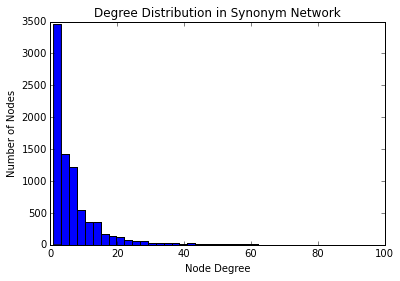

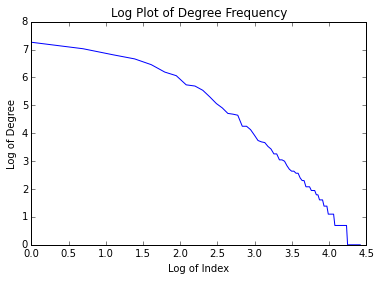

In [147]:
%reload_ext autoreload
%autoreload 2

from mrjob_7_1 import MRDegreeDistribution, MRNodeLinkCounts
import matplotlib.pyplot as plt
import math


mr_job1 = MRNodeLinkCounts(args=['input/synNet.txt', '--no-output', '--no-strict-protocols'])
mr_job2 = MRDegreeDistribution(args=['input/synNet.txt', '--no-output', '--no-strict-protocols'])

with mr_job1.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        print line
        
degree_frequency = {}
with mr_job2.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        degree, frequency =  mr_job3.parse_output_line(line)
        degree_frequency[int(degree)] = int(frequency)
print 'Number of Nodes with Just One Link:', degree_frequency[1]
print '\n'

plt.hist(degree_frequency.keys(), len(degree_frequency), weights = degree_frequency.values())
plt.title('Degree Distribution in Synonym Network')
plt.xlabel('Node Degree')
plt.ylabel('Number of Nodes')
plt.xlim(0, 100)
plt.show()

index = [math.log(float(i)) for i in range(1, len(degree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(degree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of Degree')
plt.show()


## Problem 7.2 - Shortest Path on Synonym Network

In this portion we simply leverage the previous code and run that shortest path algorithm from single source to single destination on the sysnonym network graph. The output is shown below, along with some other shortest paths found in the process of reaching the desired destination.

Since the code and driver are repeated - with just data set change - no other explanation is offered here.

In [16]:
%%writefile mrjob_7_2.py
        
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

# This class explained above.
class MRGraphInit(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                       mapper = self.mapper
                       )]
    
    # Initialize the source node of interst
    def mapper_init(self):
        self.source_node = '7827'
        
    # Output graph in the form shortest path code will use and place
    # source node in the Q since its the default frontier.
    def mapper(self, _, line):
        line = line.strip('\n')
        node, neighbors = line.split('\t')
        neighbors = ast.literal_eval(neighbors)
        
        if node == self.source_node:
            yield node, (neighbors.keys(), [node], 0, 'Q')
        else:
            yield node, (neighbors.keys(), [], sys.maxsize, 'U')        
        
class MRShortestPath(MRJob):
    
    def steps(self):
        return [MRStep(mapper = self.bfs_mapper,
                       reducer = self.bfs_reducer)]
    
    # Place nodes completed in visited state and keep opening the frontier
    # by placing new neighboring nodes in the Q.
    def bfs_mapper(self, _, line):
        line = line.strip('\n')
        
        key, value = line.split('\t')
        key = key.replace('"', '')
        neighbors, path, distance, status = ast.literal_eval(value)
        
        # If a node was in visited or unvisited state, nothing to do. Ship it over.
        if status == 'V' or status == 'U':
            yield key, (neighbors, path, distance, status)
        else:
            # If a node was in Q status in previous map step, it would have
            # been processed by reducer, and we are done with it. Mark it visited.
            # So, place it in the Q, and open up its neighbors as the new frontier
            # nodes by placing them in Q.
            yield key, (neighbors, path, distance, 'V')
            for node in neighbors:
                yield node, ('NULL', path, int(distance) + 1, 'Q')
    
    def bfs_reducer(self, key, values):
        # Some local variables to compare and store final distance, path
        # and status to set multiple lines of output from mapper for a given
        # node. Consolidate lines to carry final path, distance and Q status
        # through to the mapper again.
        min_distance = sys.maxsize
        statuses = {}
        final_neighbors = []
        current_path = None
        
        # This loop will only be relevant for 'frontier nodes' in Q.
        for neighbors, path, distance, status in values:
            statuses[status] = 1;
            # If we lines with not the max distance (infinity), we should
            # Take these distances as our distance to this node. Works ONLY
            # for unweighted graphs.
            if distance < min_distance:
                min_distance = distance
                current_path = path
            # Pick the nighbors from the non-'NULL' line - repeat of original line
            # in the graph.
            if neighbors != 'NULL':
                final_neighbors = neighbors
        # If something was in visited state alread, nothing to do. Send it along.
        if 'V' in statuses:
            yield key, (final_neighbors, path, min_distance, 'V')
        # If a node is in Q, append to its path the source of how it got
        # into the frontier land (into the Q) and output the node.
        elif 'Q' in statuses:
            current_path.append(key)
            yield key, (final_neighbors, current_path, min_distance, 'Q')
        else:
            # If this was an unvisited node, keep passing it along
            yield key, (neighbors, path, distance, status)

class MRCheckDestinationNode(MRJob):
    def steps(self):
        return [MRStep(mapper = self.frontier_mapper)]
    
    # A very simple mapper that outputs nodes that are in visited state
    # so the driver can check if desired node has been visited and terminate.
    def frontier_mapper(self, _, line):
        line = line.strip('\n')
        line = line.split('\t')
        
        items = ast.literal_eval(line[1])
        if (items[-1] == 'V'):
            yield line[0], (items[-1], items[1], items[2])
    

Overwriting mrjob_7_2.py


In [31]:
%reload_ext autoreload
%autoreload 2

from mrjob_7_2 import MRGraphInit, MRShortestPath, MRCheckDestinationNode

mr_job1 = MRGraphInit(args=['input/synNet.txt', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job2 = MRShortestPath(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job3 = MRCheckDestinationNode(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--no-strict-protocols'])

with mr_job1.make_runner() as runner:
    runner.run()

source_node = '7827'
destination_node = '536'
destination_found = False

outfile = open('/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/paths.txt', 'w')

iterations = 0
while(iterations < 10):
    with mr_job2.make_runner() as runner: 
        runner.run()
    with mr_job3.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            key, value =  mr_job3.parse_output_line(line)
            key = key.replace('"', '')
            if value[0] == 'V':
                line = line.replace('"', '')
                line = line.replace('\\', '')
                outfile.write(line + '\n')
            if key == destination_node and value[0] == 'V':
                print (source_node, destination_node), (value[1], value[2])
                destination_found = True
                break

    if destination_found:
        break

    iterations += 1

outfile.close()

('7827', '536') (['7827', '1426', '1668', '536'], 3)


In [36]:
!echo Examples of a few other paths found:
!echo
!head /Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/paths.txt
!echo
!tail /Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/paths.txt

Examples of a few other paths found:

7827	[V, [7827], 0]

1426	[V, [7827, 1426], 1]

4655	[V, [7827, 4655], 1]

7827	[V, [7827], 0]

7828	[V, [7827, 7828], 1]


5351	[V, [7827, 1426, 264, 5351], 3]

5352	[V, [7827, 1426, 264, 5352], 3]

5353	[V, [7827, 1426, 264, 5353], 3]

5354	[V, [7827, 1426, 264, 5354], 3]

536	[V, [7827, 1426, 1668, 536], 3]



## Problem 7.3 - Exploratory Data Analysis on Wikipedia Graph

In this section, we do exploratory data analysis on the provided Wikipedia graph. Note that we use the 'index' file with the inlink/outlink and node count metrics to perform this analysis - there is no need to walk the actual graph for this purpose.

This taks is accomplished by an MRJob class that reads the index file and outputs the desired metrics so that the reducer can compile / aggregate these statistics across all nodes and output them in the final step. The final step outputs the statistics indicating whether a certain count pertains to 'indegree' (incoming links) or 'outdegree' (outgoing links). **Note: Since the wikipedia graph is directed, the code keeps track of relevant direction per metric**.

THIS EDA was run in three different steps as follows:

1) First, we took a very small (1000 lines) of data from the provided full wikipedia data set and used **LOCAL** driver to run and output the EDA analysis.

2) Second, we took the same exact small data set, and ran the code on EMR, stored the output to S3. Read the S3 data and displayed the EDA analysis output.

3) Third, we ran the code on the entire data set on EMR, and dispalyed the output after reading it from S3.

All these three runs are repeated (including code blocks) and shown below.

**NOTE: Please look at the third run and output for the 'final' EDA. The first two are on just a small sample of data.**

In [21]:
%%writefile mrjob_7_3_local.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRDegreeDistribution(MRJob):
    def steps(self):
        sort_conf = {'mapred.reduce.tasks': '1'}
        return [MRStep(mapper = self.degree_mapper,
                       reducer_init = self.degree_reducer_init,
                       reducer = self.degree_reducer,
                       reducer_final = self.degree_reducer_final,
                       jobconf = sort_conf
                       )]
    
    # Output the node and its indegree / outdegree
    def degree_mapper(self, _, line):
        line = line.strip('\n')        
        title, node, indegree, outdegree = line.split('\t')
        yield node, (indegree, outdegree)
    
    def degree_reducer_init(self):
        self.indegree_frequency = {}
        self.outdegree_frequency = {}
    
    # Gather up how many nodes, how many times a given indegree happens, outdegree happens
    def degree_reducer(self, key, values):
        for indegree, outdegree in values:
            self.indegree_frequency.setdefault(indegree, 0)
            self.indegree_frequency[indegree] += 1
            self.outdegree_frequency.setdefault(outdegree, 0)
            self.outdegree_frequency[outdegree] += 1
    
    # Output the final counts and frequencies of the indegree/outdegree counts.
    def degree_reducer_final(self):
        for indegree in self.indegree_frequency:
            yield 'in', (indegree, self.indegree_frequency[indegree])
        for outdegree in self.outdegree_frequency:
            yield 'out', (outdegree, self.outdegree_frequency[outdegree])


Writing mrjob_7_3_local.py


Number of Nodes in Wikipedia Netork: 10000
Number of Nodes in Wikipedia Network with NO IN Links: 685
Number of Nodes in Wikipedia Network with NO OUT Links: 8408
Number of IN Links: 25411
Number of OUT Links: 25039
Average Number of IN Links: 2.54
Average Number of OUT Links: 2.5


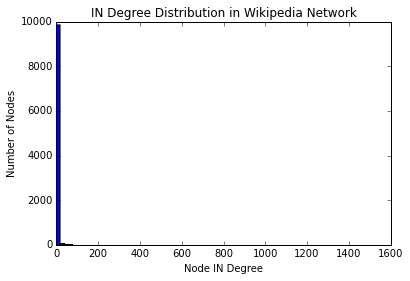

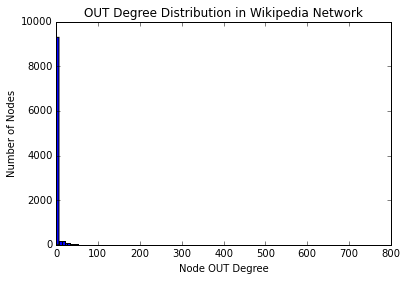

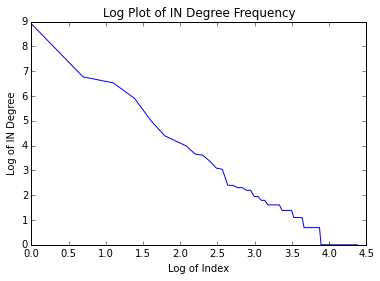

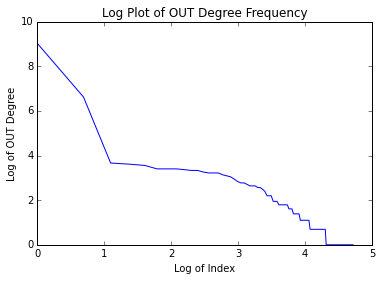

In [203]:
%reload_ext autoreload
%autoreload 2

from mrjob_7_3_local import MRDegreeDistribution
import matplotlib.pyplot as plt
import math


mr_job1 = MRDegreeDistribution(args=['input/indices_small.txt', '--no-output', '--no-strict-protocols'])

indegree_frequency = {}
outdegree_frequency = {}
with mr_job1.make_runner() as runner:
    runner.run()
    for line in runner.stream_output():
        degree_type, (degree, frequency) =  mr_job1.parse_output_line(line)
        if degree_type == 'in':
            indegree_frequency[int(degree)] = int(frequency)
        elif degree_type == 'out':
            outdegree_frequency[int(degree)] = int(frequency)

total_nodes = 0
total_indegree = 0
for indegree in indegree_frequency:
    total_nodes += indegree_frequency[indegree]
    total_indegree += indegree * indegree_frequency[indegree]
total_outdegree = 0
for outdegree in outdegree_frequency:
    total_outdegree += outdegree * outdegree_frequency[outdegree]

print 'Number of Nodes in Wikipedia Netork:', total_nodes
print 'Number of Nodes in Wikipedia Network with NO IN Links:', indegree_frequency[0]
print 'Number of Nodes in Wikipedia Network with NO OUT Links:', outdegree_frequency[0]
print 'Number of IN Links:', total_indegree
print 'Number of OUT Links:', total_outdegree
print 'Average Number of IN Links:', round(total_indegree * 1.0 / total_nodes, 2)
print 'Average Number of OUT Links:', round(total_outdegree * 1.0 / total_nodes, 2)
    
plt.hist(indegree_frequency.keys(), len(indegree_frequency), weights = indegree_frequency.values())
plt.title('IN Degree Distribution in Wikipedia Network')
plt.xlabel('Node IN Degree')
plt.ylabel('Number of Nodes')
# plt.xlim(0, 100)
plt.show()

plt.hist(outdegree_frequency.keys(), len(outdegree_frequency), weights = outdegree_frequency.values())
plt.title('OUT Degree Distribution in Wikipedia Network')
plt.xlabel('Node OUT Degree')
plt.ylabel('Number of Nodes')
# plt.xlim(0, 100)
plt.show()

index = [math.log(float(i)) for i in range(1, len(indegree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(indegree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of IN Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of IN Degree')
plt.show()

index = [math.log(float(i)) for i in range(1, len(outdegree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(outdegree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of OUT Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of OUT Degree')
plt.show()

In [207]:
%%writefile mrjob_7_3_emr.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

class MRDegreeDistribution(MRJob):
    def steps(self):
        sort_conf = {'mapred.reduce.tasks': '1'}
        return [MRStep(mapper = self.degree_mapper,
                       reducer_init = self.degree_reducer_init,
                       reducer = self.degree_reducer,
                       reducer_final = self.degree_reducer_final,
                       jobconf = sort_conf
                       )]
    
    def degree_mapper(self, _, line):
        line = line.strip('\n')        
        title, node, indegree, outdegree = line.split('\t')
        yield node, (indegree, outdegree)
    
    def degree_reducer_init(self):
        self.indegree_frequency = {}
        self.outdegree_frequency = {}
        
    def degree_reducer(self, key, values):
        for indegree, outdegree in values:
            self.indegree_frequency.setdefault(indegree, 0)
            self.indegree_frequency[indegree] += 1
            self.outdegree_frequency.setdefault(outdegree, 0)
            self.outdegree_frequency[outdegree] += 1
            
    def degree_reducer_final(self):
        for indegree in self.indegree_frequency:
            yield 'in', (indegree, self.indegree_frequency[indegree])
        for outdegree in self.outdegree_frequency:
            yield 'out', (outdegree, self.outdegree_frequency[outdegree])

if __name__ == '__main__':
    MRDegreeDistribution.run()

Overwriting mrjob_7_3_emr.py


In [208]:
!python mrjob_7_3_emr.py -r emr s3://ucb-mids-mls-hw5/gopala/indices_small.txt --output-dir=s3://ucb-mids-mls-hw5/gopala/7_3_small_out/ --no-output

using configs in /Users/gtumuluri/.mrjob.conf
Got unexpected opts from /Users/gtumuluri/.mrjob.conf: aws_acces_key_id
inferring aws_region from scratch bucket's region (us-west-2)
creating tmp directory /var/folders/n7/sy2td2bj17v5k2jxbz4yctqr0000gn/T/mrjob_7_3_emr.gtumuluri.20151026.132934.740043
writing master bootstrap script to /var/folders/n7/sy2td2bj17v5k2jxbz4yctqr0000gn/T/mrjob_7_3_emr.gtumuluri.20151026.132934.740043/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://ucb-mids-mls-hw5/gopala/tmp/mrjob_7_3_emr.gtumuluri.20151026.132934.740043/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-32V3M9104RQ6L
Created new job flow j-32V3M9104RQ6L
Job launched 31.0s ago, status STARTING: Provis

Number of Nodes in Wikipedia Netork: 10000
Number of Nodes in Wikipedia Network with NO IN Links: 685
Number of Nodes in Wikipedia Network with NO OUT Links: 8408
Number of IN Links: 25411
Number of OUT Links: 25039
Average Number of IN Links: 2.54
Average Number of OUT Links: 2.5


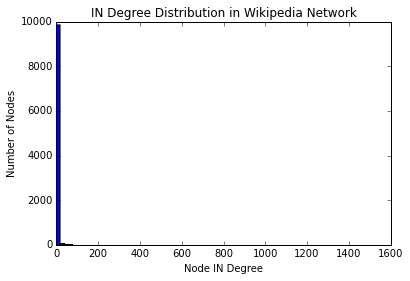

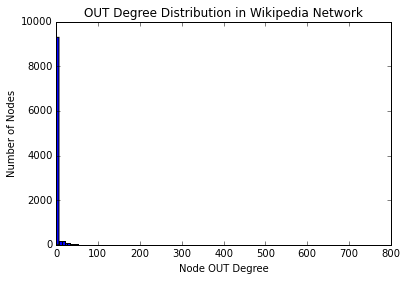

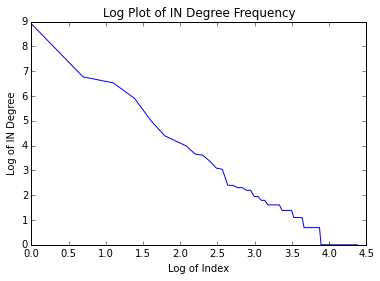

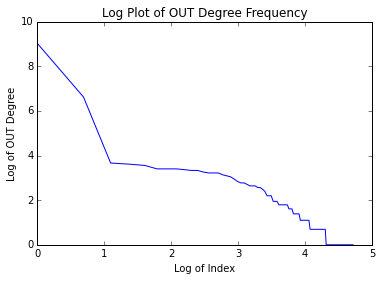

In [235]:

import urllib2
import matplotlib.pyplot as plt
import math
import ast

indegree_frequency = {}
outdegree_frequency = {}
f = urllib2.urlopen("https://s3-us-west-2.amazonaws.com/ucb-mids-mls-hw5/gopala/7_3_small_out/part-00000")
for line in f.readlines():
    line = line.strip('\n')
    degree_type, degree_stat =  line.split('\t')
    degree_type = degree_type.replace('"', '')
    degree, frequency = ast.literal_eval(degree_stat)
    if degree_type == 'in':
        indegree_frequency[int(degree)] = int(frequency)
    elif degree_type == 'out':
        outdegree_frequency[int(degree)] = int(frequency)

total_nodes = 0
total_indegree = 0
for indegree in indegree_frequency:
    total_nodes += indegree_frequency[indegree]
    total_indegree += indegree * indegree_frequency[indegree]
total_outdegree = 0
for outdegree in outdegree_frequency:
    total_outdegree += outdegree * outdegree_frequency[outdegree]

print 'Number of Nodes in Wikipedia Netork:', total_nodes
print 'Number of Nodes in Wikipedia Network with NO IN Links:', indegree_frequency[0]
print 'Number of Nodes in Wikipedia Network with NO OUT Links:', outdegree_frequency[0]
print 'Number of IN Links:', total_indegree
print 'Number of OUT Links:', total_outdegree
print 'Average Number of IN Links:', round(total_indegree * 1.0 / total_nodes, 2)
print 'Average Number of OUT Links:', round(total_outdegree * 1.0 / total_nodes, 2)
    
plt.hist(indegree_frequency.keys(), len(indegree_frequency), weights = indegree_frequency.values())
plt.title('IN Degree Distribution in Wikipedia Network')
plt.xlabel('Node IN Degree')
plt.ylabel('Number of Nodes')
# plt.xlim(0, 100)
plt.show()

plt.hist(outdegree_frequency.keys(), len(outdegree_frequency), weights = outdegree_frequency.values())
plt.title('OUT Degree Distribution in Wikipedia Network')
plt.xlabel('Node OUT Degree')
plt.ylabel('Number of Nodes')
# plt.xlim(0, 100)
plt.show()

index = [math.log(float(i)) for i in range(1, len(indegree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(indegree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of IN Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of IN Degree')
plt.show()

index = [math.log(float(i)) for i in range(1, len(outdegree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(outdegree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of OUT Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of OUT Degree')
plt.show()

In [237]:
!python mrjob_7_3_emr.py -r emr s3://ucb-mids-mls-networks/wikipedia/indices.txt --output-dir=s3://ucb-mids-mls-hw5/gopala/7_3_out/ --no-output

using configs in /Users/gtumuluri/.mrjob.conf
Got unexpected opts from /Users/gtumuluri/.mrjob.conf: aws_acces_key_id
inferring aws_region from scratch bucket's region (us-west-2)
creating tmp directory /var/folders/n7/sy2td2bj17v5k2jxbz4yctqr0000gn/T/mrjob_7_3_emr.gtumuluri.20151026.135301.612999
writing master bootstrap script to /var/folders/n7/sy2td2bj17v5k2jxbz4yctqr0000gn/T/mrjob_7_3_emr.gtumuluri.20151026.135301.612999/b.py

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

Copying non-input files into s3://ucb-mids-mls-hw5/gopala/tmp/mrjob_7_3_emr.gtumuluri.20151026.135301.612999/files/
Waiting 5.0s for S3 eventual consistency
Creating Elastic MapReduce job flow
Job flow created with ID: j-2YJL3OKLTUZT6
Created new job flow j-2YJL3OKLTUZT6
Job launched 31.0s ago, status STARTING: Provis

Number of Nodes in Wikipedia Netork: 15192277
Number of Nodes in Wikipedia Network with NO IN Links: 976256
Number of Nodes in Wikipedia Network with NO OUT Links: 9410987
Number of IN Links: 185243029
Number of OUT Links: 185243029
Average Number of IN Links: 12.19
Average Number of OUT Links: 12.19


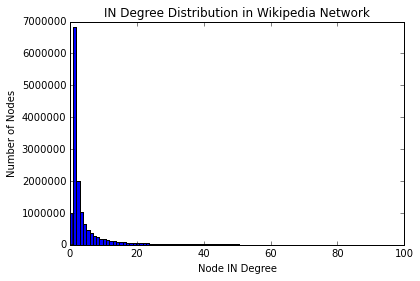

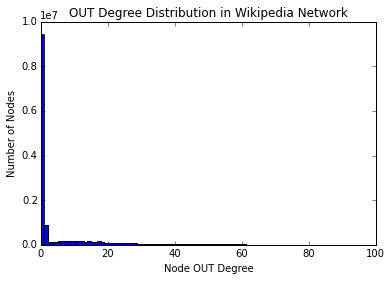

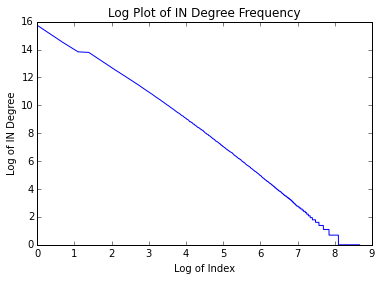

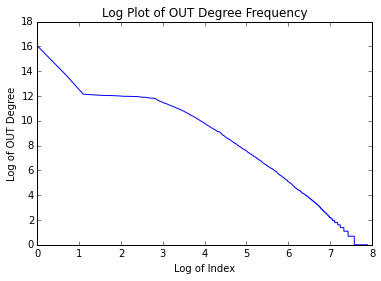

In [254]:

import urllib2
import matplotlib.pyplot as plt
import math
import ast

indegree_frequency = {}
outdegree_frequency = {}
f = urllib2.urlopen("https://s3-us-west-2.amazonaws.com/ucb-mids-mls-hw5/gopala/7_3_out/part-00000")
for line in f.readlines():
    line = line.strip('\n')
    degree_type, degree_stat =  line.split('\t')
    degree_type = degree_type.replace('"', '')
    degree, frequency = ast.literal_eval(degree_stat)
    if degree_type == 'in':
        indegree_frequency[int(degree)] = int(frequency)
    elif degree_type == 'out':
        outdegree_frequency[int(degree)] = int(frequency)

total_nodes = 0
total_indegree = 0
for indegree in indegree_frequency:
    total_nodes += indegree_frequency[indegree]
    total_indegree += indegree * indegree_frequency[indegree]
total_outdegree = 0
for outdegree in outdegree_frequency:
    total_outdegree += outdegree * outdegree_frequency[outdegree]

print 'Number of Nodes in Wikipedia Netork:', total_nodes
print 'Number of Nodes in Wikipedia Network with NO IN Links:', indegree_frequency[0]
print 'Number of Nodes in Wikipedia Network with NO OUT Links:', outdegree_frequency[0]
print 'Number of IN Links:', total_indegree
print 'Number of OUT Links:', total_outdegree
print 'Average Number of IN Links:', round(total_indegree * 1.0 / total_nodes, 2)
print 'Average Number of OUT Links:', round(total_outdegree * 1.0 / total_nodes, 2)

d = {}
for i in range(100):
    d[i] = indegree_frequency[i]

plt.hist(d.keys(), 100, weights = d.values())
plt.title('IN Degree Distribution in Wikipedia Network')
plt.xlabel('Node IN Degree')
plt.ylabel('Number of Nodes')
plt.show()

d = {}
for i in range(100):
    d[i] = outdegree_frequency[i]

plt.hist(d.keys(), len(d), weights = d.values())
plt.title('OUT Degree Distribution in Wikipedia Network')
plt.xlabel('Node OUT Degree')
plt.ylabel('Number of Nodes')
plt.xlim(0, 100)
plt.show()

index = [math.log(float(i)) for i in range(1, len(indegree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(indegree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of IN Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of IN Degree')
plt.show()

index = [math.log(float(i)) for i in range(1, len(outdegree_frequency) + 1)]
values = [math.log(float(v)) for v in sorted(outdegree_frequency.values(), reverse = True)]
plt.plot(index, values)
plt.title('Log Plot of OUT Degree Frequency')
plt.xlabel('Log of Index')
plt.ylabel('Log of OUT Degree')
plt.show()

## Problem - 7.4 - Shortest Path Distance in Wikipedia Graph

In this portion we simply leverage the previous code and run that shortest path algorithm from single source to single destination on the sysnonym network graph. The output is shown below, along with some other shortest paths found in the process of reaching the desired destination.

Since the code and driver are repeated - with just data set change - no other explanation is offered here.

In [17]:
%%writefile mrjob_7_4_wiki.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

# This class explained above.
class MRGraphInit(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                       mapper = self.mapper
                       )]
    
    # Initialize the source node of interst
    def mapper_init(self):
        self.source_node = '6176135'
        
    # Output graph in the form shortest path code will use and place
    # source node in the Q since its the default frontier.
    def mapper(self, _, line):
        line = line.strip('\n')
        node, neighbors = line.split('\t')
        neighbors = ast.literal_eval(neighbors)
        
        if node == self.source_node:
            yield node, (neighbors.keys(), [node], 0, 'Q')
        else:
            yield node, (neighbors.keys(), [], sys.maxsize, 'U')        
        
class MRShortestPath(MRJob):
    
    def steps(self):
        return [MRStep(mapper = self.bfs_mapper,
                       reducer = self.bfs_reducer)]
    
    # Place nodes completed in visited state and keep opening the frontier
    # by placing new neighboring nodes in the Q.
    def bfs_mapper(self, _, line):
        line = line.strip('\n')
        
        key, value = line.split('\t')
        key = key.replace('"', '')
        neighbors, path, distance, status = ast.literal_eval(value)
        
        # If a node was in visited or unvisited state, nothing to do. Ship it over.
        if status == 'V' or status == 'U':
            yield key, (neighbors, path, distance, status)
        else:
            # If a node was in Q status in previous map step, it would have
            # been processed by reducer, and we are done with it. Mark it visited.
            # So, place it in the Q, and open up its neighbors as the new frontier
            # nodes by placing them in Q.
            yield key, (neighbors, path, distance, 'V')
            for node in neighbors:
                yield node, ('NULL', path, int(distance) + 1, 'Q')
    
    def bfs_reducer(self, key, values):
        # Some local variables to compare and store final distance, path
        # and status to set multiple lines of output from mapper for a given
        # node. Consolidate lines to carry final path, distance and Q status
        # through to the mapper again.
        min_distance = sys.maxsize
        statuses = {}
        final_neighbors = []
        current_path = None
        
        # This loop will only be relevant for 'frontier nodes' in Q.
        for neighbors, path, distance, status in values:
            statuses[status] = 1;
            # If we lines with not the max distance (infinity), we should
            # Take these distances as our distance to this node. Works ONLY
            # for unweighted graphs.
            if distance < min_distance:
                min_distance = distance
                current_path = path
            # Pick the nighbors from the non-'NULL' line - repeat of original line
            # in the graph.
            if neighbors != 'NULL':
                final_neighbors = neighbors
        # If something was in visited state alread, nothing to do. Send it along.
        if 'V' in statuses:
            yield key, (final_neighbors, path, min_distance, 'V')
        # If a node is in Q, append to its path the source of how it got
        # into the frontier land (into the Q) and output the node.
        elif 'Q' in statuses:
            current_path.append(key)
            yield key, (final_neighbors, current_path, min_distance, 'Q')
        else:
            # If this was an unvisited node, keep passing it along
            yield key, (neighbors, path, distance, status)

class MRCheckDestinationNode(MRJob):
    def steps(self):
        return [MRStep(mapper = self.frontier_mapper)]
    
    # A very simple mapper that outputs nodes that are in visited state
    # so the driver can check if desired node has been visited and terminate.
    def frontier_mapper(self, _, line):
        line = line.strip('\n')
        line = line.split('\t')
        
        items = ast.literal_eval(line[1])
        if (items[-1] == 'V'):
            yield line[0], (items[-1], items[1], items[2])



Overwriting mrjob_7_4_wiki.py


In [35]:
%reload_ext autoreload
%autoreload 2

from mrjob_7_4_wiki import MRGraphInit, MRShortestPath, MRCheckDestinationNode

mr_job1 = MRGraphInit(args=['input/all-pages-indexed-out.txt', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job2 = MRShortestPath(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job3 = MRCheckDestinationNode(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--no-strict-protocols'])

with mr_job1.make_runner() as runner:
    runner.run()

source_node = '6176135'
destination_node = '13466359'
destination_found = False

outfile = open('/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/wikipaths.txt', 'w')

iterations = 0
while(iterations < 10):
    with mr_job2.make_runner() as runner: 
        runner.run()
    with mr_job3.make_runner() as runner: 
        runner.run()
        for line in runner.stream_output():
            key, value =  mr_job3.parse_output_line(line)
            key = key.replace('"', '')
            if value[0] == 'V':
                line = line.replace('"', '')
                line = line.replace('\\', '')
                outfile.write(line + '\n')
            if key == destination_node and value[0] == 'V':
                print (source_node, destination_node), (value[1], value[2])
                destination_found = True
                break

    if destination_found:
        break

    iterations += 1

outfile.close()

('6176135', '13466359') (['6176135', '11607791', '13466359'], 2)


In [37]:
!echo Examples of a few other paths found:
!echo
!head /Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/wikipaths.txt
!echo
!tail /Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/wikipaths.txt

Examples of a few other paths found:

6176135	[V, [6176135], 0]

10005312	[V, [6176135, 10005312], 1]

10005582	[V, [6176135, 10005582], 1]

10005890	[V, [6176135, 10005890], 1]

10015369	[V, [6176135, 10015369], 1]


13466042	[V, [6176135, 13950050, 13466042], 2]

13466107	[V, [6176135, 8298973, 13466107], 2]

13466267	[V, [6176135, 10598707, 13466267], 2]

13466323	[V, [6176135, 5285700, 13466323], 2]

13466359	[V, [6176135, 11607791, 13466359], 2]



## Problem - 7.5

In the above implemetation of the shortest path algorithm we are relying on an early termination approach whereby once the algorithm computes the shortest path to a given destination node from a given source node, we stop and output that path.

To find the 'longest' shortest path, **we must explore ALL the reachable nodes** from the source, and only terminate when no nodes are available to explore further since all of them have been visited. Of course, a graph can be disjoint and some nodes may not have been explored yet. But, those can't be reached from the source node and so we won't have to consider them. This modified algorithm is the full BFS (Breadth First Search) algorithm that when it terminates will produces shortest paths from the source to every single reachable node.

To acommplish this task, we modified our algorithm and MRJob steps/driver in the following way:

1) Initialize graph as before

2) Expand frontier and compute shortest path to frontier nodes as before

3) In each iteration, output counts of number of nodes in each of the three statuses.

4) Check if any node is in the Q status (still to be explored) - in the frontier to be explored.

5) If there are nodes in Q status, go back to step 2.

6) If no nodes in Q status, we are done - we visited all nodes reachable (unvisited nodes must be unreachable)

7) Output the longest shortest paths to the furthest nodes from source by running through the paths.

**NOTE: We actually implemented this algorithm and have shown the output below.**

## Problem - 7.6 (OPTIONAL - EXTRA CREDIT)

In this section, we actually wrote the code - MRJob classes and the driver to fully explore the graph from the source node and output all the longest distance shortest paths (furthest nodes from the source). The code follows the above outline (from 7.5) and is explained below.

This code leverage the **MRGraphInit** and the **MRShortestPath** MRJob classes previously written and documented. In addition, it uses the following two classes:

1) **MRCheckFrontierNodes** - This class outputs the number of nodes in any given one of the three statuses. The objective of this class is to provide these summary statistics so that a termination condition can be implemented. The algorithm outlined in 7.5 above terminates when no nodes are in the queue (or in status Q). This class helps know so.

2) **MROutputPaths** - This class taks the ouput of the fullly iterated and explored run of the shortest path algorithm until the final termination condition, and then outputs the paths in proper format **(source, destination), (path, distance)**, which is different from the format the intermediate stream uses to compute the shortest path.

The code is used to run on the Synonym network data, and the output is shown below. We also tried to run the code on the full Wikipedia data set, but that run did not finish in time for the submission. However, **we hope** to receive credit for the code and its successful demonstration on a sizeable Synonym network data set.

In [22]:
%%writefile mrjob_7_5_syn.py

from mrjob.job import MRJob
from mrjob.step import MRStep
import ast
import sys

# This class explained above.
class MRGraphInit(MRJob):
    def steps(self):
        return [MRStep(mapper_init = self.mapper_init,
                       mapper = self.mapper
                       )]
    
    # Initialize the source node of interst
    def mapper_init(self):
        self.source_node = '7827'
        
    # Output graph in the form shortest path code will use and place
    # source node in the Q since its the default frontier.
    def mapper(self, _, line):
        line = line.strip('\n')
        node, neighbors = line.split('\t')
        neighbors = ast.literal_eval(neighbors)
        
        if node == self.source_node:
            yield node, (neighbors.keys(), [node], 0, 'Q')
        else:
            yield node, (neighbors.keys(), [], sys.maxsize, 'U')        
        
class MRShortestPath(MRJob):
    
    def steps(self):
        return [MRStep(mapper = self.bfs_mapper,
                       reducer = self.bfs_reducer)]
    
    # Place nodes completed in visited state and keep opening the frontier
    # by placing new neighboring nodes in the Q.
    def bfs_mapper(self, _, line):
        line = line.strip('\n')
        
        key, value = line.split('\t')
        key = key.replace('"', '')
        neighbors, path, distance, status = ast.literal_eval(value)
        
        # If a node was in visited or unvisited state, nothing to do. Ship it over.
        if status == 'V' or status == 'U':
            yield key, (neighbors, path, distance, status)
        else:
            # If a node was in Q status in previous map step, it would have
            # been processed by reducer, and we are done with it. Mark it visited.
            # So, place it in the Q, and open up its neighbors as the new frontier
            # nodes by placing them in Q.
            yield key, (neighbors, path, distance, 'V')
            for node in neighbors:
                yield node, ('NULL', path, int(distance) + 1, 'Q')
    
    def bfs_reducer(self, key, values):
        # Some local variables to compare and store final distance, path
        # and status to set multiple lines of output from mapper for a given
        # node. Consolidate lines to carry final path, distance and Q status
        # through to the mapper again.
        min_distance = sys.maxsize
        statuses = {}
        final_neighbors = []
        current_path = None
        
        # This loop will only be relevant for 'frontier nodes' in Q.
        for neighbors, path, distance, status in values:
            statuses[status] = 1;
            # If we lines with not the max distance (infinity), we should
            # Take these distances as our distance to this node. Works ONLY
            # for unweighted graphs.
            if distance < min_distance:
                min_distance = distance
                current_path = path
            # Pick the nighbors from the non-'NULL' line - repeat of original line
            # in the graph.
            if neighbors != 'NULL':
                final_neighbors = neighbors
        # If something was in visited state alread, nothing to do. Send it along.
        if 'V' in statuses:
            yield key, (final_neighbors, path, min_distance, 'V')
        # If a node is in Q, append to its path the source of how it got
        # into the frontier land (into the Q) and output the node.
        elif 'Q' in statuses:
            current_path.append(key)
            yield key, (final_neighbors, current_path, min_distance, 'Q')
        else:
            # If this was an unvisited node, keep passing it along
            yield key, (neighbors, path, distance, status)

# This MRJob task allows the driver to check if there are any nodes in the Queue.
# Outputs the status [V, Q, U] and the counts of nodes in those statuses respectively.
class MRCheckFrontierNodes(MRJob):
    def steps(self):
        return [MRStep(mapper = self.frontier_mapper,
                       reducer_init = self.frontier_reducer_init,
                       reducer = self.frontier_reducer,
                       reducer_final = self.frontier_reducer_final)]
    
    def frontier_reducer_init(self):
        self.status_stats = []
        
    def frontier_mapper(self, _, line):
        line = line.strip('\n')
        line = line.split('\t')
        
        # Yield status and count of 1
        items = ast.literal_eval(line[1])
        yield items[-1], 1
    
    def frontier_reducer(self, key, value):
        # Aggregate counts of nodes in given status (just 3)
        self.status_stats.append((key, sum(value)))
    
    def frontier_reducer_final(self):
        # Output the status and number of nodes in that status.
        for status, counts in self.status_stats:
            yield status, counts

# Final MRJob class to actually output the shortest paths in a proper format of
# (source, destination), (path, distance)
class MROutputPaths(MRJob):
    def steps(self):
        return [MRStep(mapper = self.path_mapper)]
            
    def path_mapper(self, _, line):
        line = line.strip('\n')
        line = line.split('\t')
        
        line[0] = line[0].replace('"', '')
        items = ast.literal_eval(line[1])
        yield ('7827', line[0]), (items[1], len(items[1]))



Overwriting mrjob_7_5_syn.py


In [62]:
%reload_ext autoreload
%autoreload 2

import ast
from mrjob_7_5_syn import MRGraphInit, MRShortestPath, MRCheckFrontierNodes, MROutputPaths

mr_job1 = MRGraphInit(args=['input/synNet.txt', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job2 = MRShortestPath(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])
mr_job3 = MRCheckFrontierNodes(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--no-strict-protocols'])
mr_job4 = MROutputPaths(args=['/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000', '--output-dir=/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output', '--no-output', '--no-strict-protocols'])

with mr_job1.make_runner() as runner:
    runner.run()

while(1):
    with mr_job2.make_runner() as runner: 
        runner.run()
    with mr_job3.make_runner() as runner: 
        runner.run()
        statuses = {}
        for line in runner.stream_output():
            key, value =  mr_job3.parse_output_line(line)
            statuses[key] = 1
        if 'Q' not in statuses:
            break

with mr_job4.make_runner() as runner:
    runner.run()

longest_distance = 0
with open('/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000') as infile:
    for line in infile:
        line = line.strip('\n')
        line = line.split('\t')
        
        path, distance = ast.literal_eval(line[1])
        if longest_distance < int(distance):
            longest_distance = distance
print "Lognest path distance:", longest_distance
print "\n"
print "Longest paths with the longest distance are:"
with open('/Users/gtumuluri/Documents/BerkeleyMIDS/ScalableML/HW7/output/part-00000') as infile:
    for line in infile:
        line = line.strip('\n')
        line = line.split('\t')
        
        path, distance = ast.literal_eval(line[1])
        if longest_distance == int(distance):
            print line[0] + '\t' + line[1]

Lognest path distance: 11


Longest paths with the longest distance are:
["7827", "3439"]	[["7827", "1426", "1038", "95", "3021", "2756", "3022", "2088", "4159", "3440", "3439"], 11]
["7827", "3441"]	[["7827", "1426", "1038", "95", "3021", "2756", "3022", "2088", "4159", "3440", "3441"], 11]
["7827", "4990"]	[["7827", "1426", "1429", "1682", "2730", "2973", "3167", "3705", "3707", "4989", "4990"], 11]
["7827", "5747"]	[["7827", "1426", "1429", "1682", "1478", "1474", "6945", "5670", "5752", "5746", "5747"], 11]
["7827", "5748"]	[["7827", "1426", "1429", "1682", "1478", "1474", "6945", "5670", "5752", "5746", "5748"], 11]
["7827", "5749"]	[["7827", "1426", "1429", "1682", "1478", "1474", "6945", "5670", "5752", "5746", "5749"], 11]
["7827", "5750"]	[["7827", "1426", "1429", "1682", "1478", "1474", "6945", "5670", "5752", "5746", "5750"], 11]
["7827", "5751"]	[["7827", "1426", "1429", "1682", "1478", "1474", "6945", "5670", "5752", "5746", "5751"], 11]
["7827", "5953"]	[["7827", "1426", 